# Kuramoto Synchrobiology Playground

Based on https://github.com/fabridamicelli/kuramoto

In [164]:
import asyncio
import time
import traceback
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from jupyterplot import ProgressPlot
from scipy import integrate
from pythonosc.udp_client import SimpleUDPClient

In [165]:
# Integration using Euler's method
def euler_integrate(dXfunc, X0, t, sim):
    h = t[1] - t[0]
    print(f"Integrating with h={h} (found h={sim.h} in sim)")
    res = [X0]
    for tv in t:
        # Do one Euler integration step for each time step...
        # https://personal.math.ubc.ca/~pwalls/math-python/differential-equations/first-order/
        X0 = X0 + h * dXfunc(X0, tv, sim)
        res.append(X0)
    return np.array(res[:-1])

def phase_coherence(angles_vec):
        '''
        Compute global order parameter R_t - mean length of resultant vector
        '''
        suma = sum([(np.e ** (1j * i)) for i in angles_vec])
        return abs(suma / len(angles_vec))

In [166]:
# Global State
message_rate = 0.1 # inverse of sampling rate of messages to synthesizer (period in seconds)

# number of euler steps calculated per message sent to synthesizer
# use this to balance simulation accuracy against sending too many messages
# together with message rate this paramater also controls the realtime speed of the simulation
euler_steps_per_message = 10
send_osc = True
print_every = 10
run_simulation = True
osc_msg_address = "/python"
osc_dest_addr = "localhost"
osc_dest_port = 57120 # default OSC port of SuperCollider application
osc_client = SimpleUDPClient(osc_dest_addr, osc_dest_port)

# Basic Kuramoto System
The Kuramoto model is used to study a wide range of systems with synchronization behaviour. It is a system of N coupled periodic oscillators. Each oscillator has its own constant _"natural frequency"_ $\omega_i$ which it wants to maintain (this is the oscillator's preferred angular velocity). Usually, the distribution of natural frequencies is choosen to be a gaussian-like symmetric function. Usually, a random initial (angular) position $\theta_i$ is assigned to each oscillator. 

The state (position) $\theta_i$ of oscillator $i$ is governed by the following differential equation:

$
\frac{d \theta_i}{dt} = \omega_i + \frac{K}{M_i} \sum_{j} A_{ij} sin(\theta_j - \theta_i)
$

Where $K$ is the global coupling parameter and $M_i$ is a normalization factor (the number of oscillators interacting with oscillator $i$). $A$ is the adjacency matrix enconding the oscillator connections - typically binary and undirected (symmetric), such that if $i$ interacts with node $j$, then $A_{ij} = 1, otherwise 0$. The basic idea is that, given two oscillators, the one running ahead is encouraged to slow down while the one running behind to accelerate from their preferred angular velocity.

The classical set up has all nodes interacting with each other (all-to-all: a fully connected graph) - and therefore $M_i = N$. In any other case, $M_i$ is the number of nodes connected to node $i$.

See the [Ride My Kuramotocycle](https://www.complexity-explorables.org/explorables/ride-my-kuramotocycle/) applet at complexity-explorables.org for an interactive demonstration of a Kuramoto simulation. And [this MSc thesis](https://go.owu.edu/~physics/StudentResearch/2005/BryanDaniels/kuramoto_paper.pdf) for a more detailed treatment of the basic model.

In [167]:
# Set up simulation...

sim = type('KuramotoBasic', (), {})()
sim.name = "KuramotoBasic"
sim.h = 0.001 # Euler integration desired time step
sim.t = 0.

# Simulation Parameters
sim.k_coupling = 1.    # global coupling constant, typical values 0.4-2.0
sim.n_nodes = 10       # number of nodes

# Generate based on a Gaussian distribution
sim.natural_frequencies = np.random.normal(size=sim.n_nodes)

# Binary, fully connected
fc_graph = nx.erdos_renyi_graph(n=sim.n_nodes, p=1.)
sim.connectivity_matrix = nx.to_numpy_array(fc_graph)

# Randomize initial positions
sim.X0 = 2 * np.pi * np.random.random(size=sim.n_nodes)

# Dynamic position & velocity values
sim.X = sim.X0
sim.dX = np.array([])

def kuramoto_derivative(X, t, sim):
    '''
        Compute derivative (dtheta_i/dt) of all nodes at current state.
        Where:
            X: vector of current positions (angles theta) size N=number of nodes
            t: current time (this is an autonomous system, does not vary with t)
            sim: simulation parameters and current state
    '''
    assert len(X) == len(sim.natural_frequencies) == len(sim.connectivity_matrix), 'Input dimensions do not match, check lengths'

    angles_i, angles_j = np.meshgrid(X, X)
    interactions = sim.connectivity_matrix * np.sin(angles_j - angles_i)  # Aij * sin(j-i)
    dXdt = sim.natural_frequencies + sim.k_coupling * interactions.sum(axis=0)  # sum over incoming interactions
    return dXdt

sim.dXfunc = kuramoto_derivative

In [190]:
# Choose Simulation Parameters

sim.k_coupling = 0.2    # global coupling constant, typical values 0.4-2.0
sim.n_nodes = 20         # number of oscillator / nodes
sim.natural_frequencies = np.random.normal(size=sim.n_nodes)  # normal distribution of natural frequencies
fc_graph = nx.erdos_renyi_graph(n=sim.n_nodes, p=0.5)          # fully connected matrix of connectivity
sim.connectivity_matrix = nx.to_numpy_array(fc_graph)
sim.X0 = 2 * np.pi * np.random.random(size=sim.n_nodes)       # random initial positions
sim.X = sim.X0
tmax = 35.               # simulation length in seconds


# sim.k_coupling = 0.10
# sim.n_nodes = 20
# sim.natural_frequencies = np.random.normal(size=sim.n_nodes)
# fc_graph = nx.erdos_renyi_graph(n=sim.n_nodes, p=1.)
# sim.connectivity_matrix = nx.to_numpy_array(fc_graph)
# sim.X0 = 2 * np.pi * np.random.random(size=sim.n_nodes)
# sim.X = sim.X0
# tmax = 10.


(35000, 20) (35000,) (20,)


Text(0, 0.5, '$\\sin(\\theta)$')

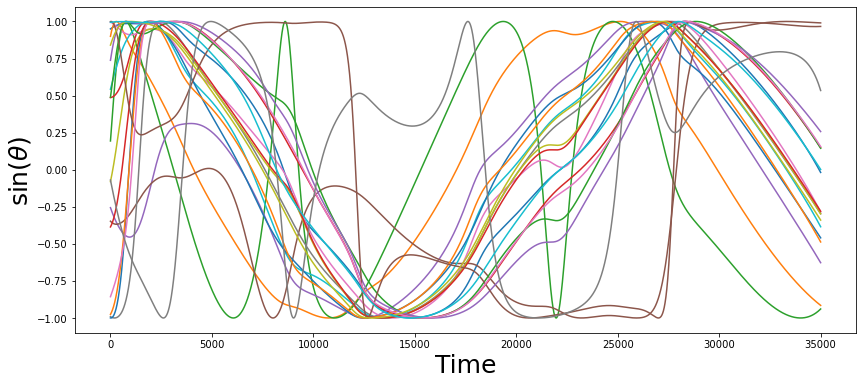

In [191]:
# Plot the results using integrate.odeint - this is what we should expect to happen in real-time using Euler

t = np.linspace(0, tmax, int(tmax/sim.h))
res_ode = integrate.odeint(sim.dXfunc, sim.X, t, args=(sim,))

print(res_ode.shape, t.shape, sim.X.shape)

_, ax = plt.subplots(figsize=(14, 6))
ax.plot(np.sin(res_ode))
ax.set_xlabel('Time', fontsize=25)
ax.set_ylabel(r'$\sin(\theta)$', fontsize=25)

Integrating with h=0.001 (found h=0.001 in sim)
(35000, 20) (35000,) (20,)


Text(0, 0.5, '$\\sin(\\theta)$')

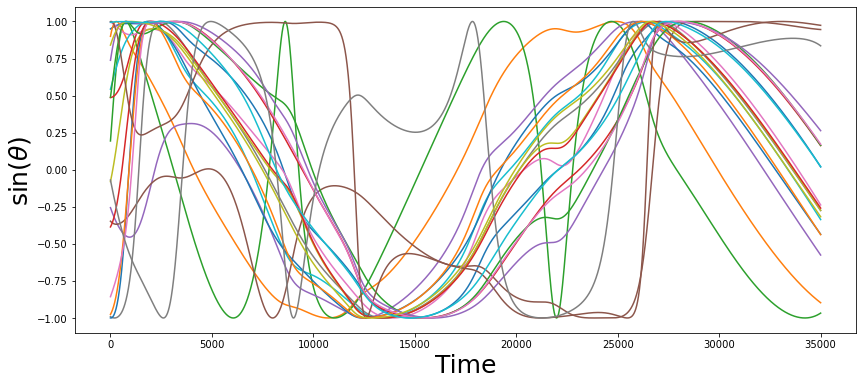

In [192]:
# Using iterative Euler Method (compare this against the results from odeint for sanity)

# Adjusting the step size h is very important here
#   need a smaller step size for accurate integration on curvy signals
#   this makes the computational cost much higher, also potentially gives accumulated error over time...
#   trade off a small h against euler_steps_per_message to keep from sending too many OSC messages

t = np.arange(0., tmax, step=sim.h)
sim.X = sim.X0

# Integrate for Nt steps
res_eul = euler_integrate(sim.dXfunc, sim.X, t, sim)
print(res_eul.shape, t.shape, sim.X.shape)
_, ax = plt.subplots(figsize=(14, 6))
ax.plot(np.sin(res_eul))
ax.set_xlabel('Time', fontsize=25)
ax.set_ylabel(r'$\sin(\theta)$', fontsize=25)

(-0.01, 1.0)

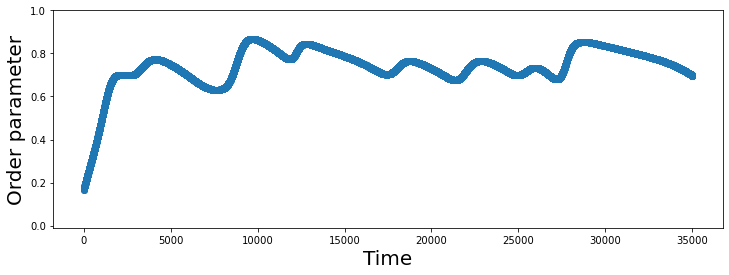

In [193]:
# Plot phase coherence over time
_, ax = plt.subplots(figsize=(12, 4))
ax.plot([phase_coherence(vec) for vec in res_ode], 'o')
ax.set_ylabel('Order parameter', fontsize=20)
ax.set_xlabel('Time', fontsize=20)
ax.set_ylim((-0.01, 1))

# Real-time Simulation

The simulation runs indefinitely in an async coroutine `sim_task()` and therefore will not block the jupyter notebook runtime. To stop the simulation, set `run_simulation` to `False`.

In [194]:
# Some reasonable runtime parameters for the Realtime simulation...
global realtime_plot
realtime_plot = None
message_rate = 0.1             # 10fps - delay between updates (OSC & graph) in seconds
euler_steps_per_message = 5    # number of simulation time steps calculated per update
print_every=1000               # print output to the jupyter notebook every 1000 time steps 
sim.X = sim.X0                 # reset positions to initial values

In [195]:
# Main simulation thread
async def sim_task():
    """
    Entry point for Simulation process.
    """
    global run_simulation
    global osc_client
    global euler_steps_per_message
    global send_osc
    global print_every
    global realtime_plot
    
    print("Run Simulation...")
    i=0

    # TODO: Add option to run for N steps
    while run_simulation: # Simulation Step
        timestamp = time.time()
        osc_parcel = ["sim", sim.name, "t", sim.t]
        
        # Do one Euler step
        # https://personal.math.ubc.ca/~pwalls/math-python/differential-equations/first-order/
        sim.dX = sim.dXfunc(sim.X, sim.t, sim)
        sim.X = sim.X + sim.h * sim.dX
        sim.t += sim.h
        
        osc_parcel.append("X"); osc_parcel.append(sim.X.tolist());
        osc_parcel.append("dX"); osc_parcel.append(sim.dX.tolist());

        if i % euler_steps_per_message == 0:
            if send_osc:
                osc_client.send_message(osc_msg_address, osc_parcel)
                
            if realtime_plot is not None:
                #realtime_plot.update(sim.dX[3])
                realtime_plot.update([np.sin(sim.X).tolist()])

            if print_every != False:
                if i % print_every == 0:
                    print(osc_parcel)
            
            await asyncio.sleep(message_rate) # scheduler tick

        sim.t += sim.h
        i+=1
    
    print("Exit Simulation")

def run_sim(osc=True, print_output=1000):
    '''
        Run the real-time simulation.
    '''
    global run_simulation
    global print_every
    
    print_every = print_output
    
    try:
        send_osc = osc
        if send_osc:
            osc_client.send_message(osc_msg_address, ["volume", 1.0]); #unmute sonification
        run_simulation = True
        loop=asyncio.get_event_loop()
        task=loop.create_task(sim_task())
        print("Simulation Running...")
    except KeyboardInterrupt as e:
        exp = traceback.format_exc()
        raise e
    except Exception as e:
        exp = traceback.format_exc()
        print("Exit with Errors")
        raise e
    finally:
        # Do any necessary cleanup....
        print("Cleanup")

def stop_sim():
    global run_simulation
    global send_osc
    global osc_client
    run_simulation = False
    if send_osc:
        osc_client.send_message(osc_msg_address, ["volume", 0.0]); #mute sonification


In [196]:
# Randomize positions
sim.X0 = 2 * np.pi * np.random.random(size=sim.n_nodes)
sim.X = sim.X0

In [197]:
# Run simulation...
sim.X = sim.X0
print(tmax)
line_names=[str(x) for x in range(sim.n_nodes)]
realtime_plot = ProgressPlot(
    line_names=line_names, 
    #x_lim=[0, tmax * 100.], 
    y_lim=[-1.0, 1.0], 
    height=500, 
    width=1000
)
run_sim(osc=True, print_output=False)

35.0


Simulation Running...
Cleanup
Run Simulation...


In [206]:
# Randomize natural frequencies
sim.natural_frequencies = np.random.normal(size=sim.n_nodes)

In [204]:
# Change coupling while sim is running..
sim.k_coupling = 0.6    # global coupling constant, typical values 0.4-2.0
message_rate = 0.1             # 10fps - delay between updates (OSC & graph) in seconds
euler_steps_per_message = 50    # number of simulation time steps calculated per update

In [207]:
# Stop the simulation...
stop_sim()
realtime_plot.finalize()

Exit Simulation


# Modifications to Basic Kuramoto

During our workdays together we discussed a number of possible modifications that could be made to the basic Kuramoto model: 

$
\frac{d \theta_i}{dt} = \omega_i + \frac{K}{M_i} \sum_{j} A_{ij} sin(\theta_j - \theta_i)
$


## 1. Adding a driving force (heartbeat) and/or noise parameter

Additional terms could be added to the basic model equation to either drive the model (using the heart beat) or add noise (making dynamics less stable).

$
\frac{d \theta_i}{dt} = \omega_i + \frac{K}{M_i} \sum_{j} A_{ij} sin(\theta_j - \theta_i) + noise(t) + heartbeat(t)
$

* [Noise-induced synchronization in the Kuramoto model (2020)](https://arxiv.org/abs/2004.00294)


## 2. Variations in Network Topology

Using network topologies of less densely connected and more densely connected areas to describe an entire world, or subsets of the world, and subsets of subsets. For example a sentinel could be considered as a small community of highly connected oscillators.

![img/network-topologies.png](img/network-topologies.png)
![img/network-topo.png](img/network-topo.png)






## 3. Modifications to Connectivity Matrix

There are a number of simple modifications we could make to the connectivity matrix $A$ to make the system more versatile and to represent different scenarios in the world. 

* Use continuous values rather than binary (on/off) connection strengths. This would allow us to specify some agents to have a "weak" connection and some to have a "strong" connection. Alessio suggests making connection strength a set of quantized values to make analysis easier. For example, four connection strengths: "strong" / "medium" / "weak" / "none"
* Use negative connection values, so that certain oscillators actually repel each other rather than try to synchronize.

We also considered expanding the model to allow for asymmetric coupling matrix $K$ such that it is possible for: 

$
K_{ij} \ne K_{ji}
$

In this model $K$ effectively combines the function of $K$ and $A$ into a single term: 

$
\frac{d \theta_i}{dt} = \omega_i + \frac{1}{M_i} \sum_{j} K_{ij} sin(\theta_j - \theta_i)
$

In this situation, two oscillators can interact but not have a reciprocal influence on each other. Such an extension would allow, for example, to have a microplastic exert a strong influence to synchronize on an organic agent, but have the organic agent exert little or no influence for the microplastic to change.

Such a modification would also make it possible to introduce the heart beat of the visitor as a unique oscillator that interacts with all or many of the agents in the world without being influenced by them in return. This is an alternative approach to the idea of the heart beat be a driving force term.


* [Kuramoto model with oriented, weighted and signed interactions](https://arxiv.org/abs/1807.11410)

## 4. Choice of Natural Frequencies & Initial Conditions
Not only a gaussian distribution, but maybe natural frequency and initial conditions are more meaningful - related in an important way to the world and its nature.

## 5. Metastability and Chimera States

Studying modifications to the Kuramoto model that promote metastability and chimera states is probably of use to us, because we are looking to create systems with interesting dynamics that could easily be pushed into different states and display ecological behaviors such as flickering and tipping points.

The most influential paper exploring this topic is Shanahan (2009), which proposes adding a phase lag parameter  $\alpha$ to the equation. Francesca suggests that this lag parameter could also, like the noise term, be time-dependent.

$
\frac{d \theta_i}{dt} = \omega_i + \frac{K}{M_i} \sum_{j} A_{ij} sin(\theta_j - \theta_i - \alpha)
$



* [Metastable Chimera States in Community-Structured Oscillator Networks (2009)](https://arxiv.org/abs/0908.3881)
* [Earthquake sequencing: chimera states with Kuramoto model dynamics on directed graphs (2015)](https://npg.copernicus.org/articles/22/499/2015/)
* [Higher-order interactions promote chimera states (2022)](https://arxiv.org/abs/2204.00037)



## 6. Variations on Oscillator Behavior

The oscillators don't need to just have a fixed frequency. Some suggestions have been made to give them more interesting behavior. For example: a 2021 paper suggests having "run and tumble" oscillation, where the angular velocity moves in fits and starts. 

* [Kuramoto model with run-and-tumble dynamics (2021)](https://arxiv.org/abs/2108.00124)

Another paper suggests adding inertia to the Kuramoto model. The inertia model has been used to successfully model the synchronization of fireflies.

* [Kuramoto oscillators under the effect of inertia (2017)](https://arxiv.org/abs/1712.10111)

_Second-order Kuramoto Model with Inertia_

$
m \frac{d^2 \theta_i}{dt^2} + \frac{d \theta_i}{dt} = \omega_i + \frac{K}{M_i} \sum_{j} A_{ij} sin(\theta_j - \theta_i)
$





## 7. Memory and Learning

Sissel and Alessio discussed adding elements of memory and learning to the coupling between oscillators, such that if agents have been in sychronicity in the past then it might be easier or more difficult for them to form connections in the future. 

* [A Kuramoto Model with Inertia and Hebbian Learning (2022)](https://arxiv.org/abs/2203.12090)

## 8. Metaparameters

Measurements of synchronicity, asynchronicity, metastability, chimera states and more... would be useful to be able to get simpler, low-dimensional values that give us an idea of how the world and sub-communities within the world are behaving. For example, we have a "phase coherence" metric in the basic model above. The paper on chimera states also proposes some metrics for metastability.


* [Using Machine Learning to understand Kuramoto systems (2021)](https://arxiv.org/abs/2109.08918)